In [1]:
# Step 1: Import Libraries
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import List
from multiprocessing import Pool, cpu_count
import time
import psutil
%pip install gputil


try:
    import GPUtil
    gpu_available = True
except ImportError:
    gpu_available = False

  Preparing metadata (setup.py) ... done
  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7392 sha256=4f2d04fe21bbdce4b37a1423518ec53210ac500e7544fde02ba6c53b5a13d9c8
  Stored in directory: /root/.cache/pip/wheels/2b/4d/8f/55fb4f7b9b591891e8d3f72977c4ec6c7763b39c19f0861595
Successfully built gputil


In [2]:
# Step 2: Define Data Classes for Node & Source
@dataclass
class GridNode:
    id: int
    demand: float
    max_capacity: float
    transmission_loss: float  # percent (0.05 = 5%)

@dataclass
class EnergySource:
    id: int
    max_supply: float
    cost_per_mw: float
    availability: float  # between 0 and 1

In [16]:
# Step 3: Initialize Nodes and Sources
def initialize(num_nodes=10, num_sources=3):
    nodes = [GridNode(i, np.random.uniform(50, 150), 200, np.random.uniform(0.05, 0.15)) for i in range(num_nodes)]
    sources = [EnergySource(i, np.random.uniform(300, 500), np.random.uniform(5, 15), np.random.uniform(0.8, 1.0)) for i in range(num_sources)]
    return nodes, sources


In [4]:
# Step 4: Chromosome Encoding
def encode_chromosome(num_nodes, num_sources):
    return np.random.dirichlet(np.ones(num_sources), size=num_nodes)

In [5]:
# Step 5: Fitness Function

def fitness_function(chromosome, nodes, sources):
    total_cost, loss_penalty, demand_penalty, supply_penalty = 0, 0, 0, 0
    supply_used = np.zeros(len(sources))

    for i, node in enumerate(nodes):
        total_from_sources = 0
        for j, source in enumerate(sources):
            allocated = chromosome[i][j] * node.demand
            loss = allocated * node.transmission_loss
            effective = allocated - loss
            total_from_sources += effective
            supply_used[j] += allocated

            total_cost += allocated * source.cost_per_mw
            loss_penalty += loss

        if total_from_sources < node.demand:
            demand_penalty += (node.demand - total_from_sources) ** 2

    for j, source in enumerate(sources):
        if supply_used[j] > source.max_supply:
            supply_penalty += (supply_used[j] - source.max_supply) ** 2

    return -(total_cost + loss_penalty + demand_penalty + supply_penalty)


In [6]:
# Step 6: Parallel Fitness Evaluation
def parallel_fitness(population, nodes, sources):
    with Pool(processes=cpu_count()) as pool:
        results = pool.starmap(fitness_function, [(chrom, nodes, sources) for chrom in population])
    return results


In [7]:
# Step 7: Selection
def select_parents(population, fitness_scores):
    idx = np.argsort(fitness_scores)[-2:]
    return [population[idx[0]], population[idx[1]]]

In [8]:
# Step 8: Crossover
def crossover(p1, p2):
    point = np.random.randint(1, p1.shape[0])
    child = np.vstack((p1[:point], p2[point:]))
    return child

In [9]:
# Step 9: Mutation
def mutate(chromosome, mutation_rate=0.1):
    if np.random.rand() < mutation_rate:
        rand_row = np.random.randint(0, chromosome.shape[0])
        chromosome[rand_row] = np.random.dirichlet(np.ones(chromosome.shape[1]))
    return chromosome

In [10]:
# Step 10: GA Main Function (While Loop)
def run_ga(nodes, sources, generations=50, pop_size=20, parallel=True):
    population = [encode_chromosome(len(nodes), len(sources)) for _ in range(pop_size)]
    best_scores = []
    generation = 0

    while generation < generations:
        if parallel:
            fitness_scores = parallel_fitness(population, nodes, sources)
        else:
            fitness_scores = [fitness_function(chrom, nodes, sources) for chrom in population]

        best_scores.append(max(fitness_scores))
        parents = select_parents(population, fitness_scores)

        new_population = []
        for _ in range(pop_size):
            child = crossover(*parents)
            child = mutate(child)
            new_population.append(child)

        population = new_population
        generation += 1

    return best_scores

In [11]:
# Step 11: Baseline Model
def run_baseline(nodes, sources):
    chromosome = np.zeros((len(nodes), len(sources)))
    sorted_sources = sorted(sources, key=lambda s: s.cost_per_mw)

    for i, node in enumerate(nodes):
        demand_remaining = node.demand
        for source in sorted_sources:
            j = source.id
            supply_available = source.max_supply * source.availability
            allocation = min(demand_remaining, supply_available)
            chromosome[i][j] = allocation / node.demand
            demand_remaining -= allocation
            if demand_remaining <= 0:
                break

    return fitness_function(chromosome, nodes, sources)

In [12]:
# Step 12: Run over 24-hour cycle
nodes, sources = initialize()
serial_time_24h = []
parallel_time_24h = []
cpu_serial = []
cpu_parallel = []
gpu_serial = []
gpu_parallel = []

def clamp(value, min_val=0, max_val=100):
    """Ensure value stays within bounds"""
    return max(min_val, min(value, max_val))

for hour in range(24):
    # Serial GA
    cpu_before = psutil.cpu_percent(interval=1)
    start_serial = time.time()
    serial_score = run_ga(nodes, sources, parallel=False)
    end_serial = time.time()
    cpu_after = clamp(psutil.cpu_percent(interval=1))  # Clamp negative values
    serial_time_24h.append(end_serial - start_serial)
    cpu_serial.append(cpu_after)

    if gpu_available:
        gpus = GPUtil.getGPUs()
        gpu_load = gpus[0].load * 100 if gpus else 0
        gpu_serial.append(clamp(gpu_load))
    else:
        gpu_serial.append(0)

    # Parallel GA
    cpu_before = psutil.cpu_percent(interval=1)
    start_parallel = time.time()
    parallel_score = run_ga(nodes, sources, parallel=True)
    end_parallel = time.time()
    cpu_after = clamp(psutil.cpu_percent(interval=1))  # Clamp negative values
    parallel_time_24h.append(end_parallel - start_parallel)
    cpu_parallel.append(cpu_after)

    if gpu_available:
        gpus = GPUtil.getGPUs()
        gpu_load = gpus[0].load * 100 if gpus else 0
        gpu_parallel.append(clamp(gpu_load))
    else:
        gpu_parallel.append(0)

    # Print results with absolute values for scores
    print(f"Hour {hour + 1}/24 Results:")
    print("Serial GA Avg Fitness:", round(abs(np.mean(serial_score)), 2))
    print("Parallel GA Avg Fitness:", round(abs(np.mean(parallel_score)), 2))
    print("Baseline Fitness:", round(abs(run_baseline(nodes, sources)), 2))
    print("CPU Usage (Serial):", cpu_serial[-1], "%")
    print("GPU Usage (Serial):", gpu_serial[-1], "%")
    print("CPU Usage (Parallel):", cpu_parallel[-1], "%")
    print("GPU Usage (Parallel):", gpu_parallel[-1], "%")
    print("-" * 40)

Hour 1/24 Results:
Serial GA Avg Fitness: 15025.77
Parallel GA Avg Fitness: 14969.15
Baseline Fitness: 385060.49
CPU Usage (Serial): 55.5 %
GPU Usage (Serial): 0 %
CPU Usage (Parallel): 3.5 %
GPU Usage (Parallel): 0 %
----------------------------------------
Hour 2/24 Results:
Serial GA Avg Fitness: 14969.55
Parallel GA Avg Fitness: 14997.36
Baseline Fitness: 385060.49
CPU Usage (Serial): 3.0 %
GPU Usage (Serial): 0 %
CPU Usage (Parallel): 3.5 %
GPU Usage (Parallel): 0 %
----------------------------------------
Hour 3/24 Results:
Serial GA Avg Fitness: 14968.54
Parallel GA Avg Fitness: 14958.36
Baseline Fitness: 385060.49
CPU Usage (Serial): 7.0 %
GPU Usage (Serial): 0 %
CPU Usage (Parallel): 3.0 %
GPU Usage (Parallel): 0 %
----------------------------------------
Hour 4/24 Results:
Serial GA Avg Fitness: 14983.7
Parallel GA Avg Fitness: 15028.01
Baseline Fitness: 385060.49
CPU Usage (Serial): 4.0 %
GPU Usage (Serial): 0 %
CPU Usage (Parallel): 10.6 %
GPU Usage (Parallel): 0 %
--------

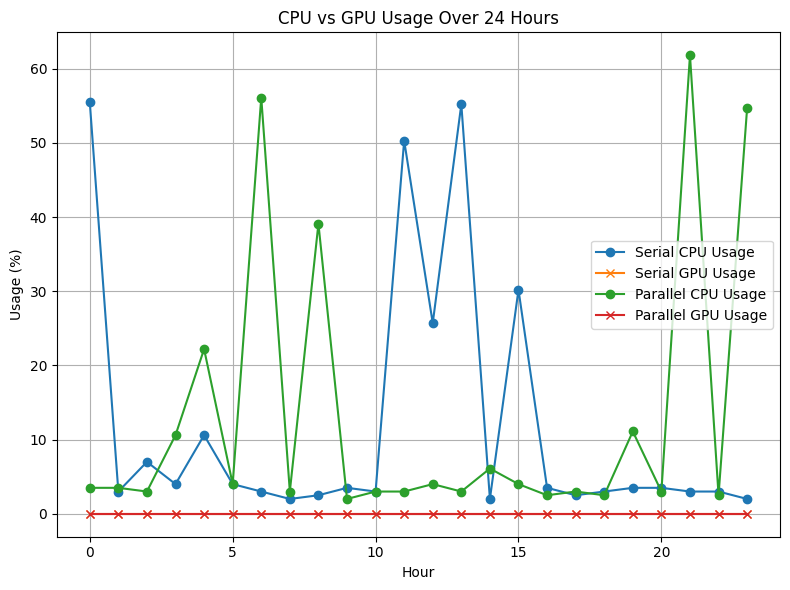

In [13]:
# Step 13: Visualizations
# ---------------------------------------------
plt.figure(figsize=(8, 6))
plt.plot(cpu_serial, label='Serial CPU Usage', marker='o')
plt.plot(gpu_serial, label='Serial GPU Usage', marker='x')
plt.plot(cpu_parallel, label='Parallel CPU Usage', marker='o')
plt.plot(gpu_parallel, label='Parallel GPU Usage', marker='x')
plt.xlabel("Hour")
plt.ylabel("Usage (%)")
plt.title("CPU vs GPU Usage Over 24 Hours")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

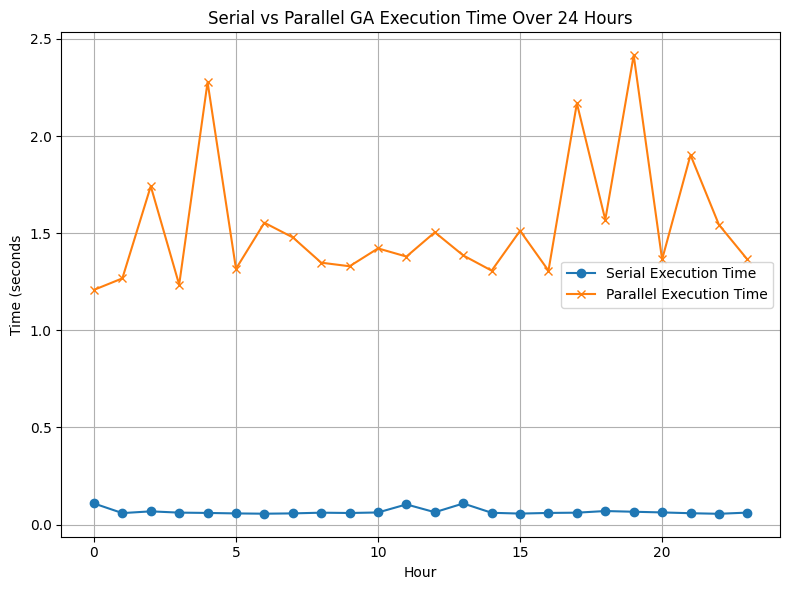

In [14]:
plt.figure(figsize=(8, 6))
plt.plot(serial_time_24h, label='Serial Execution Time', marker='o')
plt.plot(parallel_time_24h, label='Parallel Execution Time', marker='x')
plt.xlabel("Hour")
plt.ylabel("Time (seconds")
plt.title("Serial vs Parallel GA Execution Time Over 24 Hours")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

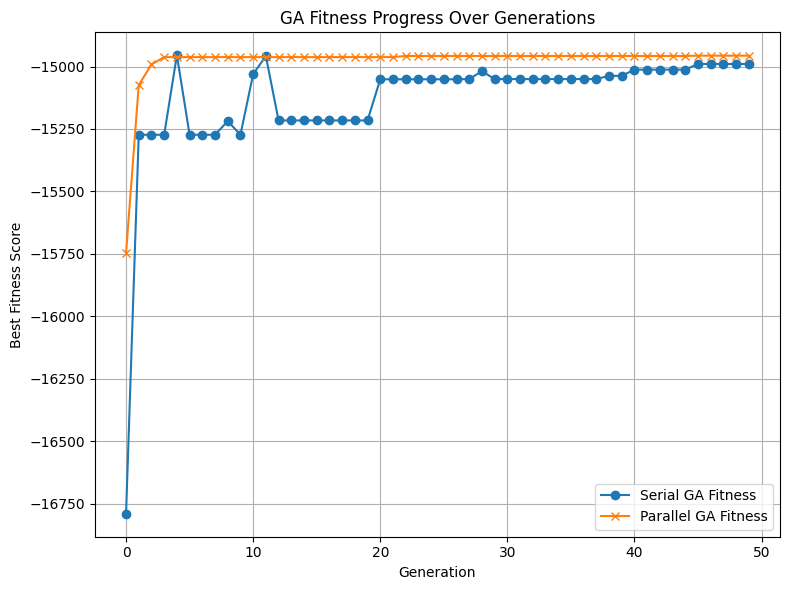

In [17]:
# Run GA once more to get fitness trends
best_serial = run_ga(nodes, sources, generations=50, pop_size=20, parallel=False)
best_parallel = run_ga(nodes, sources, generations=50, pop_size=20, parallel=True)

plt.figure(figsize=(8, 6))
plt.plot(best_serial, label='Serial GA Fitness', marker='o')
plt.plot(best_parallel, label='Parallel GA Fitness', marker='x')
plt.xlabel("Generation")
plt.ylabel("Best Fitness Score")
plt.title("GA Fitness Progress Over Generations")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


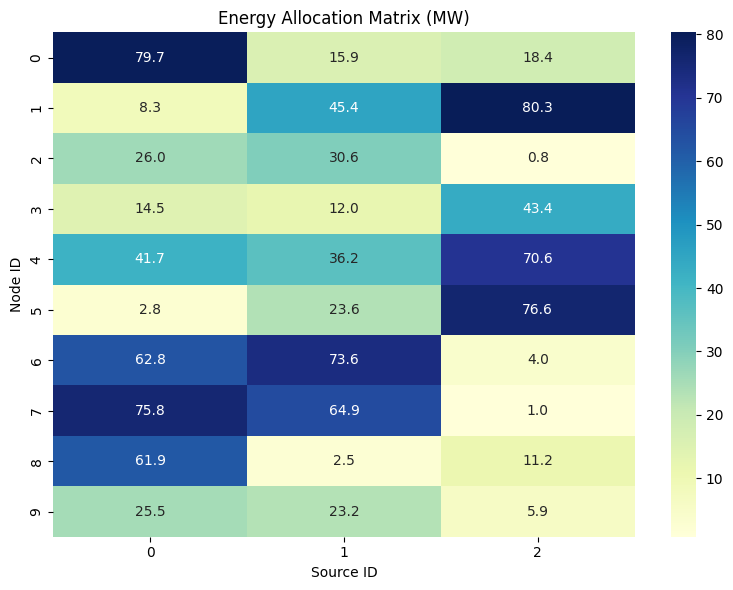

In [19]:
import seaborn as sns

#energy allocation heatmap
final_chromosome = encode_chromosome(len(nodes), len(sources))
allocation_matrix = final_chromosome * np.array([node.demand for node in nodes]).reshape(-1, 1)

plt.figure(figsize=(8, 6))
sns.heatmap(allocation_matrix, annot=True, cmap="YlGnBu", fmt=".1f")
plt.xlabel("Source ID")
plt.ylabel("Node ID")
plt.title("Energy Allocation Matrix (MW)")
plt.tight_layout()
plt.show()


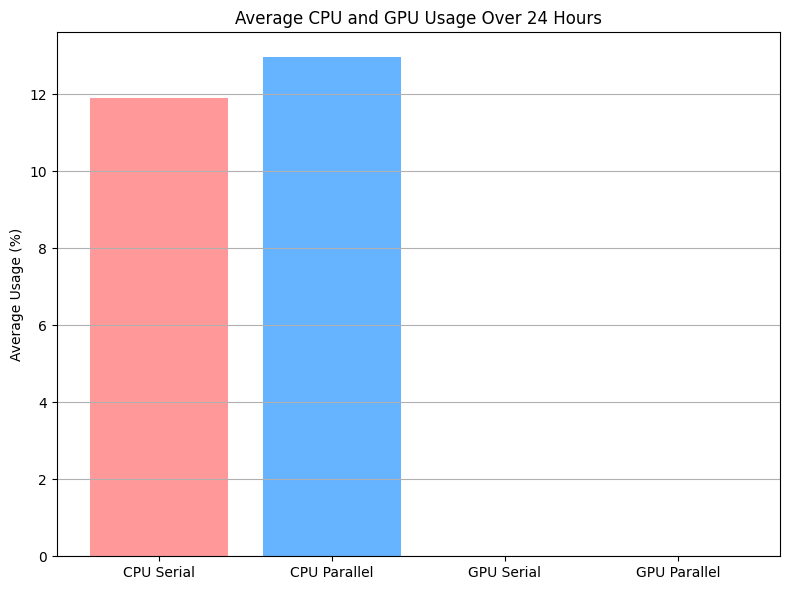

In [20]:
#barplot of CPU/GPU usage
avg_cpu_serial = np.mean(cpu_serial)
avg_cpu_parallel = np.mean(cpu_parallel)
avg_gpu_serial = np.mean(gpu_serial)
avg_gpu_parallel = np.mean(gpu_parallel)

labels = ['CPU Serial', 'CPU Parallel', 'GPU Serial', 'GPU Parallel']
values = [avg_cpu_serial, avg_cpu_parallel, avg_gpu_serial, avg_gpu_parallel]

plt.figure(figsize=(8, 6))
plt.bar(labels, values, color=['#FF9999', '#66B3FF', '#99FF99', '#FFCC99'])
plt.ylabel("Average Usage (%)")
plt.title("Average CPU and GPU Usage Over 24 Hours")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


/tmp/ipython-input-21-2495923150.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([serial_time_24h, parallel_time_24h], labels=['Serial', 'Parallel'])


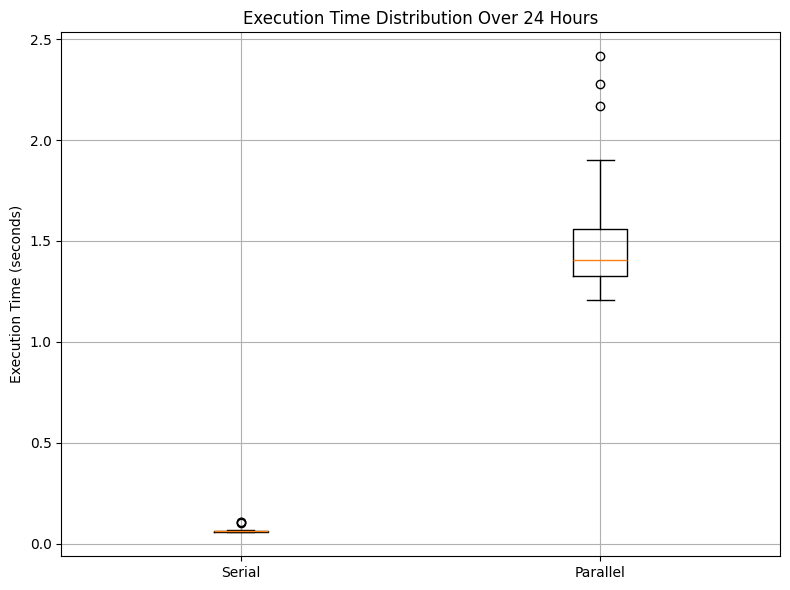

In [21]:
#boxplot pf execution times
plt.figure(figsize=(8, 6))
plt.boxplot([serial_time_24h, parallel_time_24h], labels=['Serial', 'Parallel'])
plt.ylabel("Execution Time (seconds)")
plt.title("Execution Time Distribution Over 24 Hours")
plt.grid(True)
plt.tight_layout()
plt.show()


In [22]:
print("\n=== Average Execution Time ===")
print("Serial GA:", round(np.mean(serial_time_24h), 2), "seconds")
print("Parallel GA:", round(np.mean(parallel_time_24h), 2), "seconds")


=== Average Execution Time ===
Serial GA: 0.07 seconds
Parallel GA: 1.54 seconds
